
## 1. Define the Problem

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

## 2. Gather the Data

In [1]:
train_csv_path = './data/train.csv'
test_csv_path = './data/test.csv'

## 3. Prepare Data for Consumption

### 3.1 Import Libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### 3.2 Meet and Greet Data

In [3]:
train_df = pd.read_csv(train_csv_path)

test_df = pd.read_csv(test_csv_path)

dataframes = [train_df, test_df]

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
707,708,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S
631,632,0,3,"Lundahl, Mr. Johan Svensson",male,51.0,0,0,347743,7.0542,NaN,S
478,479,0,3,"Karlsson, Mr. Nils August",male,22.0,0,0,350060,7.5208,NaN,S
538,539,0,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S
224,225,1,1,"Hoyt, Mr. Frederick Maxfield",male,38.0,1,0,19943,90.0000,C93,S
376,377,1,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.2500,NaN,S
264,265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q


### 3.21 Describe the data

- **Survived**: It is a binary nominal datatype of 1 for survived and 0 for did not survive.

- **Pclass**: Ordinal datatype for the ticket category, 1 = 1st, 2 = 2nd, 3 = 3rd.

- **Name**: Nomal variable that may include the passenger title such as Master, Mr or Miss. Will be used for feature engineering.

- **Sex**: Nominal feature that may be male or female.

- **Age**: Quantitative feature for the passenger age.

- **SibSp**: Quantitative feature, # of siblings / spouses aboard the Titanic.

- **Parch**: Quantitative feature, # of parents / children aboard the Titanic..

- **Ticket**: Nominal feature, Ticket number

- **Fare**: Quantitative feature, how much did the passenger pay for his ticket.

- **Cabin**: Nominal datatype, cabin number.

- **Embarked**: Nominal variable, Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton


### 3.22 Data Cleaning: Correcting, Completing, Creating, and Converting

As we can see here, there are a lot of things to do.

In [6]:
print('Train columns with null values:\n', train_df.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', test_df.isnull().sum())
print("-"*10)

train_df.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Fortune, Miss. Alice Elizabeth",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### Completing

Every feature that has count < total element is a candidate to be completed.

#### Drop useless columns

I will drop three columns, PassengerId is just a sequential number, Cabin has 687 (~77% of the dataset) of null values and I really can't see any valuable information in Ticket.

In [7]:
drop_cols = ['Cabin', 'Ticket', 'PassengerId']

for df in dataframes:
    df.drop(drop_cols, axis=1, inplace = True)

#### Completing Ages

As we can see there are 177 missing values in the Age column.
My first approach was to fill missing values with the mean of the ages, but then I  thought that a better plan was to replace them depending on the mean of certain groups since the age may differ by groups and categories of passengers.

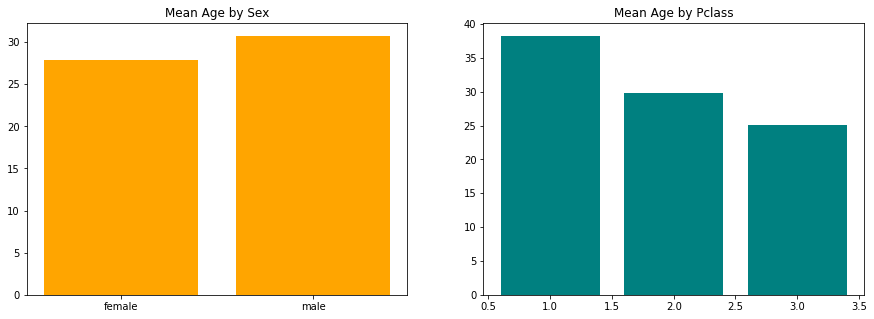

In [8]:
mean_age_by_sex = train_df.groupby('Sex')['Age'].mean()
mean_age_by_pclass = train_df.groupby('Pclass')['Age'].mean()

f = plt.figure(figsize=(15,5))

ax = f.add_subplot(121)
ax.set_title("Mean Age by Sex")
ax.bar(mean_age_by_sex.keys(), mean_age_by_sex.values, color='orange')

ax2 = f.add_subplot(122)
ax2.set_title("Mean Age by Pclass")
ax2.bar(mean_age_by_pclass.keys(), mean_age_by_pclass.values, color='teal')


plt.show()

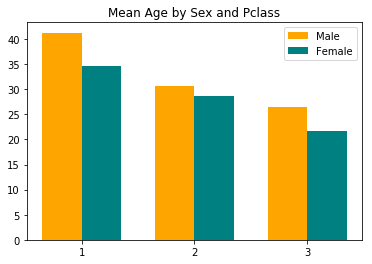

In [9]:
males, females = train_df[train_df['Sex'] == 'male'], train_df[train_df['Sex'] == 'female']
males = males.groupby('Pclass')['Age'].mean()
females = females.groupby('Pclass')['Age'].mean()

fig, ax = plt.subplots()

ind = np.arange(3)
width = 0.35

p1 = ax.bar(ind, males.values, width, color='orange')

p2 = ax.bar(ind + width, females.values, width, color='teal')

ax.set_title('Mean Age by Sex and Pclass')
ax.set_xticklabels(males.keys())

ax.legend((p1[0], p2[0]), ('Male', 'Female'))
ax.set_xticks(ind + width / 2)
ax.autoscale_view()

plt.show()

So we fill the null values with their corresponding age mean by Sex and Pclass

In [10]:
mean_ages = train_df.groupby(['Sex', 'Pclass'])['Age'].mean()

for df in dataframes:
    for idx, row in df.iterrows():
        if(np.isnan(row['Age'])):
            df.at[idx,'Age'] = mean_ages[row['Sex']][row['Pclass']]


Then we fill the Embarked the mode and the Fare with the median.

In [11]:
for df in dataframes:
    # If there is a dataset that have great outliers, I'll prefer median.
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    

    

#### Creating

In [12]:
## CREATING
drop_cols = ['Name']

for df in dataframes:    
    #Discrete variables
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    
    min_title = 10
    
    title_names = (df['Title'].value_counts() < min_title)
    
    df['Title'] = df['Title'].apply(lambda x: 'Misc' if title_names.loc[x]== True else x)
    
    df.drop(drop_cols, axis=1, inplace = True)

#### Correcting

In [13]:
def normalize(col):
    return (col-col.min())/(col.max()-col.min())

for df in dataframes:
    df['Fare'] = df['Fare'].apply(lambda x: x if x < 150 else 150)
    df['Age'] = df['Age'].apply(lambda x: x if x < 80 else 80)
    df['FamilySize'] = df['FamilySize'].apply(lambda x: x if x < 6 else 6)
    
    df['Fare'] = normalize(df['Fare'])
    df['Age'] = normalize(df['Age'])
    df['FamilySize'] = normalize(df['FamilySize'])
    df['Parch'] = normalize(df['Parch'])
    df['SibSp'] = normalize(df['SibSp'])

#### Converting

In [14]:
## CONVERTING
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

### 3.24 Da-Double Check Cleaned Data

Now that we've cleaned our data, let's do a discount da-double check! This is important, so we don't overfit our model. Meaning, the algorithm is so specific to a given subset, it cannot accurately generalize another subset, from the same dataset. It's important our algorithm has not seen the subset we will use to test, so it doesn't "cheat" by memorizing the answers.

In [15]:
train_df.sample(15)

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
662,0,1,0.585323,0.000,0.000000,0.170583,0.0,0,1,0,0,1,0,0,0,1,0
99,0,2,0.421965,0.125,0.000000,0.173333,0.2,0,1,0,0,1,0,0,0,1,0
457,1,1,0.429653,0.125,0.000000,0.345750,0.2,1,0,0,0,1,0,0,0,0,1
646,0,3,0.233476,0.000,0.000000,0.052639,0.0,0,1,0,0,1,0,0,0,1,0
607,1,1,0.334004,0.000,0.000000,0.203333,0.0,0,1,0,0,1,0,0,0,1,0
42,0,3,0.327816,0.000,0.000000,0.052639,0.0,0,1,1,0,0,0,0,0,1,0
674,0,2,0.381009,0.000,0.000000,0.000000,0.0,0,1,0,0,1,0,0,0,1,0
355,0,3,0.346569,0.000,0.000000,0.063333,0.0,0,1,0,0,1,0,0,0,1,0
72,0,2,0.258608,0.000,0.000000,0.490000,0.0,0,1,0,0,1,0,0,0,1,0
844,0,3,0.208344,0.000,0.000000,0.057750,0.0,0,1,0,0,1,0,0,0,1,0


In [16]:
print('Train columns with null values: \n', train_df.isnull().sum())
print("-"*10)
print (train_df.info())
print("-"*10)

print('Test/Validation columns with null values: \n', test_df.isnull().sum())
print("-"*10)
print (test_df.info())
print("-"*10)

train_df.describe(include = 'all')

Train columns with null values: 
 Survived        0
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
FamilySize      0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Title_Master    0
Title_Misc      0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
Age             891 non-null float64
SibSp           891 non-null float64
Parch           891 non-null float64
Fare            891 non-null float64
FamilySize      891 non-null float64
Sex_female      891 non-null uint8
Sex_male        891 non-null uint8
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Title_Master    891 non-null uint8
Title_Misc      891 non-null uint8
Title_Miss      891 non-null ui

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.363140,0.065376,0.063599,0.194998,0.167677,0.352413,0.647587,0.188552,0.086420,0.725028,0.044893,0.030303,0.204265,0.580247,0.140292
std,0.486592,0.836071,0.166890,0.137843,0.134343,0.227441,0.269725,0.477990,0.477990,0.391372,0.281141,0.446751,0.207186,0.171516,0.403390,0.493796,0.347485
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.268032,0.000000,0.000000,0.052736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.327816,0.000000,0.000000,0.096361,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,3.000000,0.447097,0.125000,0.000000,0.206667,0.200000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.25 Split Training and Testing Data

We will split the training data in three datasets; 70/15/15 split. 

In [17]:
n = len(train_df)

train_size = int(n*0.7)
test_size = int(n*0.85)

train_df[:train_size].to_csv('./clean_data/train.csv', index=False)
train_df[train_size:test_size].to_csv('./clean_data/test.csv', index=False)
train_df[train_size:].to_csv('./clean_data/valid.csv', index=False)
test_df.to_csv('./clean_data/kaggle.csv', index=False)

---

## CHECKPOINT

---

## 4. Perform Exploratory Analysis with Statistics
Anybody who has ever worked with data knows, garbage-in, garbage-out (GIGO). Therefore, it is important to deploy descriptive and graphical statistics to look for potential problems, patterns, classifications, correlations and comparisons in the dataset. In addition, data categorization (i.e. qualitative vs quantitative) is also important to understand and select the correct hypothesis test or data model.

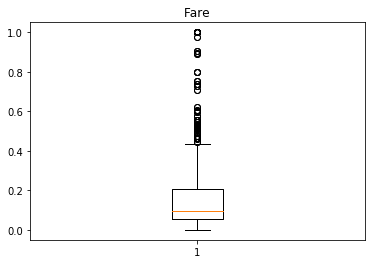

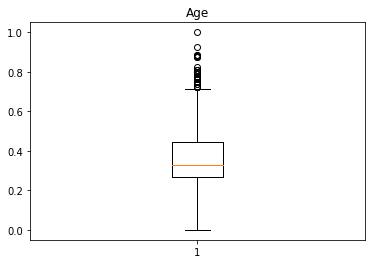

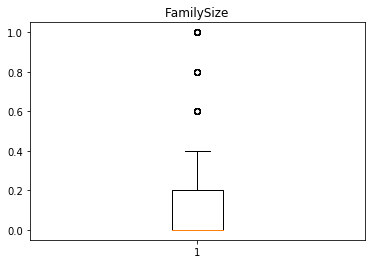

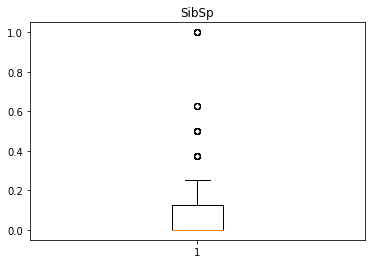

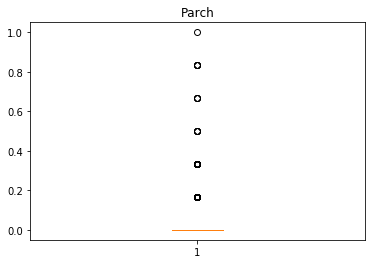

In [18]:
plt.title('Fare')
plt.boxplot(train_df['Fare'])
plt.show()

plt.title('Age')
plt.boxplot(train_df['Age'])
plt.show()

plt.title('FamilySize')
plt.boxplot(train_df['FamilySize'])
plt.show()

plt.title('SibSp')
plt.boxplot(train_df['SibSp'])
plt.show()

plt.title('Parch')
plt.boxplot(train_df['Parch'])
plt.show()

print()

## 5. Model Data

Like descriptive and inferential statistics, data modeling can either summarize the data or predict future outcomes. Your dataset and expected results, will determine the algorithms available for use. It's important to remember, algorithms are tools and not magical wands or silver bullets. You must still be the master craft (wo)man that knows how-to select the right tool for the job. An analogy would be asking someone to hand you a Philip screwdriver, and they hand you a flathead screwdriver or worst a hammer. At best, it shows a complete lack of understanding. At worst, it makes completing the project impossible. The same is true in data modelling. The wrong model can lead to poor performance at best and the wrong conclusion (that’s used as actionable intelligence) at worst.

In [19]:
class TitanicDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, transform=None):
        data = np.genfromtxt(csv_path, delimiter=',', skip_header=1)
        self.X = data[:,1:]
        self.Y = data[:,0]
        self.transform = transform

    def __getitem__(self, index):
        x = self.X[index].astype(np.float32)
        y = self.Y[index].astype(np.float32)
   
        if self.transform is not None:
            x = self.transform(x)

        return x, np.array([y])

    def __len__(self):
        n, _= self.X.shape
        return n

In [20]:
transform = transforms.Compose([transforms.ToTensor()])


train_dataset = TitanicDataset('./clean_data/train.csv', transform=None)
test_dataset = TitanicDataset('./clean_data/test.csv', transform=None)
valid_dataset = TitanicDataset('./clean_data/valid.csv', transform=None)



loaders = {
    "train":torch.utils.data.DataLoader(train_dataset, batch_size=12),
    "test": torch.utils.data.DataLoader(test_dataset, batch_size=12),
    "valid": torch.utils.data.DataLoader(valid_dataset, batch_size=12)
}

In [21]:
use_cuda = torch.cuda.is_available()

In [22]:
class NeuronalNetwork(nn.Module):
    def __init__(self):
        super(NeuronalNetwork, self).__init__()
        
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 1)
        
        self.dropout = nn.Dropout(p=0.25)
        self.sigmoid = nn.Sigmoid()
     
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.sigmoid(self.fc5(x))
        
        return x
    
network = NeuronalNetwork()

if use_cuda:
    network.cuda()

In [23]:
criterion = torch.nn.BCELoss()

optimizer = optim.Adam(network.parameters(), lr=0.001)

In [24]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    print("start training for {} epochs ...".format(n_epochs))

    valid_loss_min = np.Infinity
  
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()    # --- set model to train mode
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
  
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
           
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
            

        train_loss = train_loss / len(loaders['train'].dataset)
        valid_loss = valid_loss / len(loaders['valid'].dataset)

        if valid_loss <= valid_loss_min:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format( epoch, train_loss, valid_loss ),end="")
            print('  Saving model ...')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        elif epoch % 10 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format( epoch, train_loss, valid_loss ))
    
    print("done")
    return model

In [25]:
train_model = True

if train_model:
    train(50, loaders, network, optimizer, criterion, use_cuda, 'model.pt')

start training for 50 epochs ...
Epoch: 1 	Training Loss: 0.548019 	Validation Loss: 0.444248  Saving model ...
Epoch: 2 	Training Loss: 0.466034 	Validation Loss: 0.413293  Saving model ...
Epoch: 4 	Training Loss: 0.458179 	Validation Loss: 0.397313  Saving model ...
Epoch: 6 	Training Loss: 0.442603 	Validation Loss: 0.393239  Saving model ...
Epoch: 7 	Training Loss: 0.441946 	Validation Loss: 0.392364  Saving model ...
Epoch: 9 	Training Loss: 0.442551 	Validation Loss: 0.385718  Saving model ...
Epoch: 10 	Training Loss: 0.425678 	Validation Loss: 0.386154
Epoch: 11 	Training Loss: 0.431432 	Validation Loss: 0.382208  Saving model ...
Epoch: 12 	Training Loss: 0.426466 	Validation Loss: 0.377029  Saving model ...
Epoch: 20 	Training Loss: 0.414968 	Validation Loss: 0.381574
Epoch: 30 	Training Loss: 0.393559 	Validation Loss: 0.397603
Epoch: 40 	Training Loss: 0.394352 	Validation Loss: 0.405792
Epoch: 50 	Training Loss: 0.374114 	Validation Loss: 0.440336
done


Use the best possible model

In [26]:
network.load_state_dict(torch.load('model.pt'))

## 6. Validate and Implement Data Model

After you've trained your model based on a subset of your data, it's time to test your model. This helps ensure you haven't overfit your model or made it so specific to the selected subset, that it does not accurately fit another subset from the same dataset. In this step we determine if our [model overfit, generalize, or underfit our dataset](https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html).

In [27]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        output = model(data)

        loss = criterion(output, target)
        
        test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))
    
        pred = torch.round(output.data)

        target = target.data.view_as(pred)
        correct += np.sum(pred.eq(target).numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, network, criterion, use_cuda)

Test Loss: 0.377153


Test Accuracy: 82% (111/134)


## 7. Optimize and Strategize

#### Logs


- (Starting) Test Loss: 0.533963  - Test Accuracy: 74% (130/178) - 100 epochs

- (sigmoid to relus in model) Test Loss: 0.519375 - Test Accuracy: 75% (135/178) - 100 epochs

- (remove Fare outliers) Test Loss: 0.515917 - Test Accuracy: 76% (136/178) - 100 epochs

- (remove Age outliers) Test Loss: 0.532391 - Test Accuracy: 75% (135/178) - 100 epochs

- (Age normalization) Test Loss: 0.505303 - Test Accuracy: 76% (136/178) - 100 epochs

- (more normalization) Test Loss: 0.536085 - Test Accuracy: 75% (134/178) - 100 epochs

- (more normalization) Test Loss: 0.504762 - Test Accuracy: 74% (133/178) - 100 epochs

- (more linear units) Test Loss: 1.695051 - Test Accuracy: 76% (136/178) - 100 epochs

- (fill age by sex and Pclass) Test Loss: 0.480582 - Test Accuracy: 77% (138/178) - 30 epochs

- (increase batch_size from 2 to 12) Test Loss: 0.472785- Test Accuracy: 78% (140/178) - 30 epochs

- (split data 70/15/15 instead of 60/20/20) Test Loss: 0.379704 - Test Accuracy: 81% (109/134) - 50 epochs

## Kaggle Result

In [28]:
csv_url = './clean_data/kaggle.csv'
network.eval()

data = np.genfromtxt(csv_url, delimiter=',', skip_header=1)
data = torch.from_numpy(data).type(torch.FloatTensor)
pred = torch.round(network(data))
df = pd.DataFrame(pred.data.numpy().astype(int))
df.index = range(892, 1310)
df.index.names = ['PassengerId']
df.to_csv('./kaggle_result.csv', header=['Survived'])
print('ready')

ready


## Submission
**Kaggle result submitted on 11 of March of 2019, 01:33.**

![kaggle_titanic_result.png](kaggle_titanic_result.png)
